In [1]:
import pandas as pd
import numpy as np
import gcnIO
import os
from functools import reduce

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from scipy import interp

import matplotlib.pyplot as plt
import seaborn
plt.rc('font', family='Times New Roman')
import matplotlib_venn
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model_dir = '../data/GCN/training/2018_09_26_12_36_23/'

args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(data_file)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5


Hyper-Parameters read from ../data/GCN/training/2018_09_26_12_36_23/hyper_params.txt
Data comes from ../data/pancancer/iref_multiomics_norm_methnewpromonly_ncglabels_fpkm.h5
{'hidden_dims': [50, 40, 30, 20, 10], 'data': '../data/pancancer/iref_multiomics_norm_methnewpromonly_ncglabels_fpkm.h5', 'epochs': 7000, 'lr': 0.001, 'decay': 0.0005, 'support': 2, 'loss_mul': 30.0, 'dropout': 0.5, 'cv_runs': 10}


## Read Predictions

In [3]:
pred_all = []
sets_all = []
no_cv = 0
for cv_dir in os.listdir(model_dir):
    if cv_dir.startswith('cv_'):
        predictions = pd.DataFrame.from_csv(os.path.join(model_dir, cv_dir, 'predictions.tsv'), sep='\t', header=0)
        pred_all.append(predictions)
        y_train, y_test, train_mask, test_mask = gcnIO.read_train_test_sets(os.path.join(model_dir, cv_dir))
        sets_all.append((y_train, y_test, train_mask, test_mask))
        no_cv += 1
print ("Read predictions from {} CV runs".format(no_cv))

Read predictions from 10 CV runs


## Get ensemble predictions

In [4]:
# get node names
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes.set_index('ID')
nodes['label'] = np.logical_or(y_train, y_test)
# construct ensemble data frame
ensemble_predictions = reduce(lambda left,right: pd.merge(left,right,on='Name'), pred_all)
# get the names corrected
ensemble_predictions.columns = ['Name'] + ['Prob_pos_{}'.format(i) for i in range(1, no_cv+1)]
# restore the IDs which were lost during merging (together with the correct order)
ensemble_predictions = nodes.join(ensemble_predictions, lsuffix='2')
ensemble_predictions.drop('Name2', axis=1, inplace=True)
ensemble_predictions.set_index('ID', inplace=True)
# add columns for mean statistics (number predictions, mean prediction, std)
number_cols = [i for i in ensemble_predictions.columns if i.startswith('Prob_pos_')]
ensemble_predictions['Num_Pos'] = (ensemble_predictions[number_cols] > 0.5).sum(axis=1)
ensemble_predictions['Mean_Pred'] = ensemble_predictions[number_cols].mean(axis=1)
ensemble_predictions['Std_Pred'] = ensemble_predictions[number_cols].std(axis=1)
# write to file
ens_pred_sorted = ensemble_predictions.sort_values(by='Mean_Pred', ascending=False)
ens_pred_sorted.to_csv(os.path.join(model_dir, 'ensemble_predictions.tsv'), sep='\t')
ens_pred_sorted.head()

,label,Name,Prob_pos_1,Prob_pos_2,Prob_pos_3,Prob_pos_4,Prob_pos_5,Prob_pos_6,Prob_pos_7,Prob_pos_8,Prob_pos_9,Prob_pos_10,Num_Pos,Mean_Pred,Std_Pred
ID,,,,,,,,,,,,,,,
ENSG00000100393,True,EP300,0.0,1.000000,1.0,0.999999,1.0,1.0,1.000000,1.000000,1.0,1.000000,9,0.900000,0.316228
ENSG00000005339,True,CREBBP,0.0,1.000000,1.0,0.999999,1.0,1.0,1.000000,1.000000,1.0,1.000000,9,0.900000,0.316228
ENSG00000116478,False,HDAC1,0.0,1.000000,1.0,0.999999,1.0,1.0,1.000000,0.999999,1.0,1.000000,9,0.900000,0.316228
ENSG00000141510,True,TP53,0.0,1.000000,1.0,0.999997,1.0,1.0,1.000000,0.999999,1.0,0.999998,9,0.899999,0.316228
ENSG00000091831,True,ESR1,0.0,0.999999,1.0,0.999990,1.0,1.0,0.999999,0.999996,1.0,0.999998,9,0.899998,0.316227


# Average ROC Curve

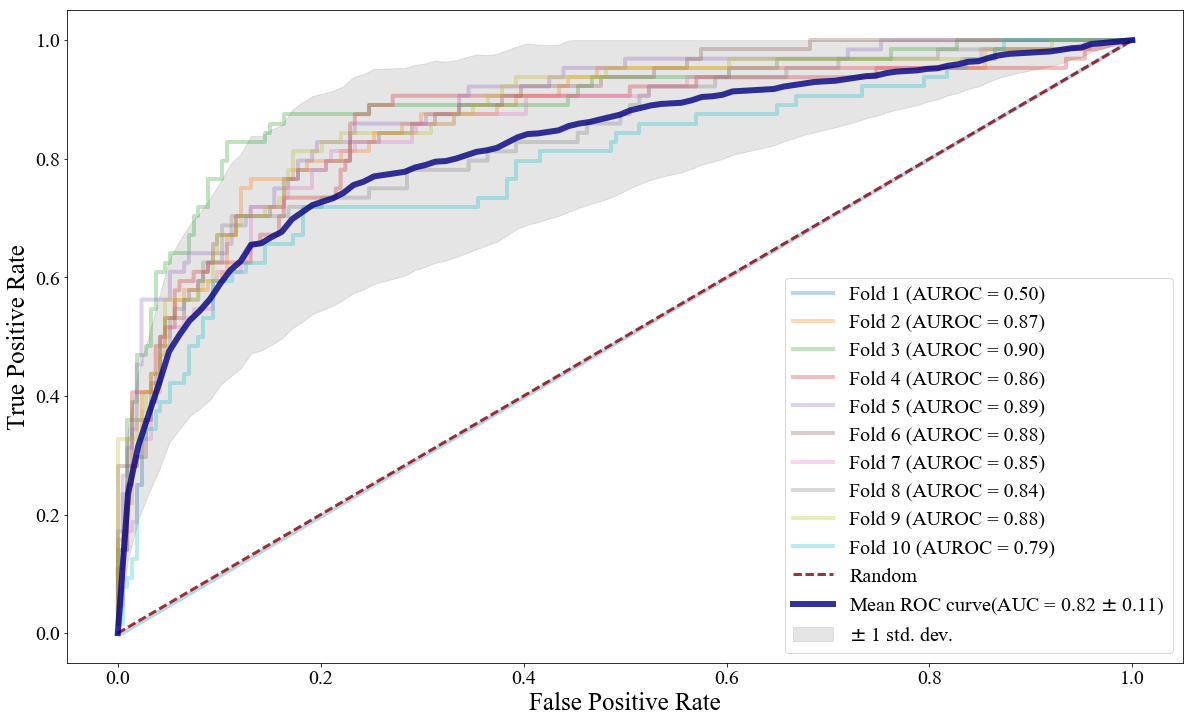

In [5]:
# construct test set statistics
fig = plt.figure(figsize=(20, 12))

k = 1
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for pred in pred_all:
    y_t = sets_all[k-1][1]
    m_t = sets_all[k-1][3]
    fpr, tpr, _ = roc_curve(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    auroc = roc_auc_score(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    aucs.append(auroc)
    plt.plot(fpr, tpr, lw=4, alpha=0.3, label='Fold %d (AUROC = %0.2f)' % (k, auroc))
    k += 1

# plot random line
plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='darkred',
         label='Random', alpha=.8)

# plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=r'Mean ROC curve(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=6, alpha=.8)

# plot std dev
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.tick_params(axis='both', labelsize=20)
fig.savefig(os.path.join(model_dir, 'mean_ROC_curve.svg'))
fig.savefig(os.path.join(model_dir, 'mean_ROC_curve.png'), dpi=300)

## Average PR Curve

1.0 1.0 0.0


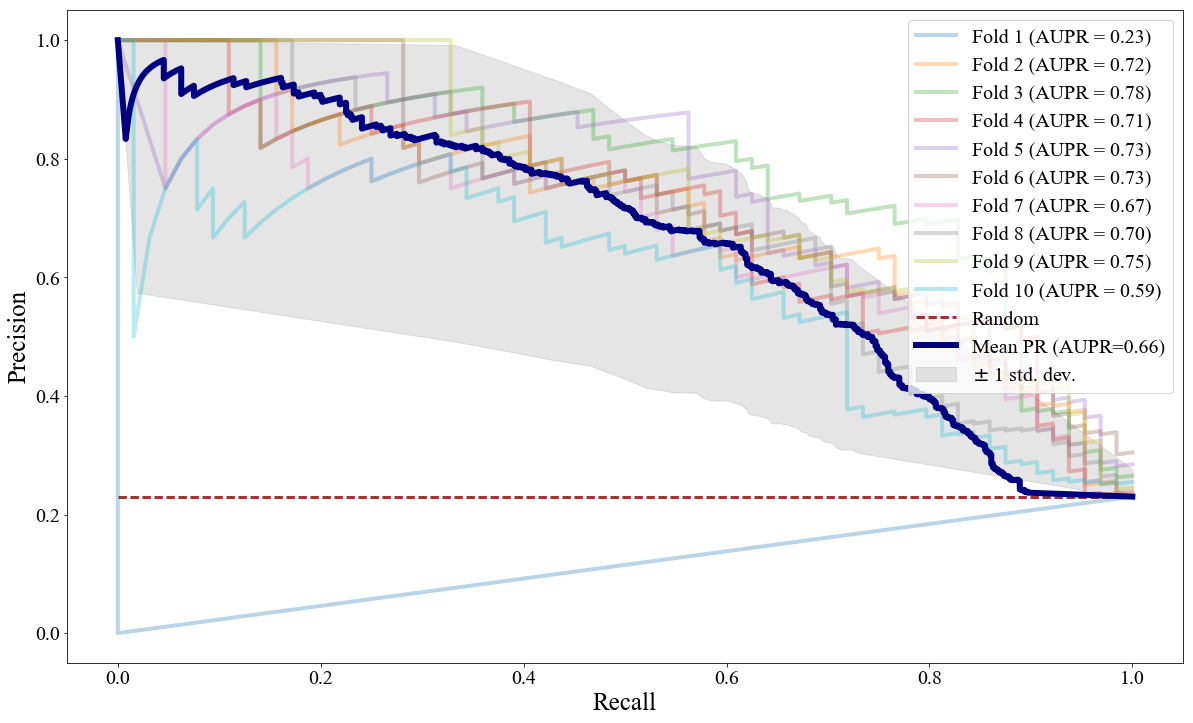

In [6]:
fig = plt.figure(figsize=(20, 12))

k = 1
y_true = []
y_pred = []
pr_values = []
rec_values = []
sample_thresholds = np.linspace(0, 1, 100)
no_pos = []
no_total = []
for pred in pred_all:
    y_t = sets_all[k-1][1] # test labels
    m_t = sets_all[k-1][3] # test mask
    pr, rec, thr = precision_recall_curve(probas_pred=pred[m_t].Prob_pos, y_true=y_t[m_t])
    no_pos.append(y_t.sum())
    no_total.append(m_t.sum())
    pr_values.append(interp(sample_thresholds, thr, pr[:-1]))
    #pr_values[-1][-1] = 1.0
    rec_values.append(interp(sample_thresholds, thr, rec[:-1]))
    aupr = average_precision_score(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    plt.plot(rec, pr, lw=4, alpha=0.3, label='Fold %d (AUPR = %0.2f)' % (k, aupr))
    y_true.append(y_t[m_t])
    y_pred.append(pred[m_t].Prob_pos)
    k += 1

# plot random line
rand_perf = np.mean(no_pos) / np.mean(no_total)
plt.plot([0, 1], [rand_perf, rand_perf], linestyle='--', lw=3, color='darkred',
         label='Random', alpha=.8)

# plot mean curve (PR curve over all folds)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mean_precision, mean_recall, mean_thresholds = precision_recall_curve(y_true, y_pred)
label = 'Mean PR (AUPR=%.2f)' % (auc(mean_recall, mean_precision))
plt.plot(mean_recall, mean_precision, label=label, lw=6, color='navy')

# plot std dev
std_pr = np.std(pr_values, axis=0)
mean_pr = np.mean(pr_values, axis=0)
mean_rec = np.mean(rec_values, axis=0)
pr_upper = np.minimum(mean_pr + std_pr, 1)
pr_lower = np.maximum(mean_pr - std_pr, 0)
pr_upper = np.append(pr_upper, 1.)
pr_lower = np.append(pr_lower, 1.)
mean_rec = np.append(mean_rec, 0.)
print (pr_upper[-1], pr_lower[-1], mean_rec[-1])

plt.fill_between(mean_rec, pr_lower, pr_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Recall', fontsize=25)
plt.ylabel('Precision', fontsize=25)
plt.legend(loc='upper right', prop={'size':20})
fig.savefig(os.path.join(model_dir, 'mean_PR_curve.svg'))
fig.savefig(os.path.join(model_dir, 'mean_PR_curve.png'), dpi=300)

In [7]:
distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([mean_recall, mean_precision]).T)**2, axis=1))
idx = np.argmin(distances)
print (mean_recall[idx], mean_precision[idx])
best_threshold = mean_thresholds[idx]
print ("Optimal classification threshold: {}".format(best_threshold))

BEST_THRESHOLD = best_threshold


0.6140625 0.6517412935323383
Optimal classification threshold: 0.8016895651817322


## Overlap with NCG Cancer Genes

In [8]:
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

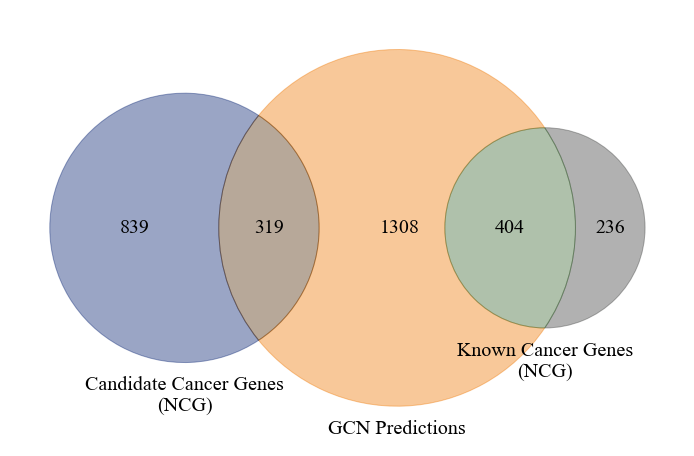

In [9]:
fig = plt.figure(figsize=(14, 8))
v = matplotlib_venn.venn3([set(known_cancer_genes_innet),
                           set(ensemble_predictions[ensemble_predictions.Mean_Pred >= BEST_THRESHOLD].Name),
                           set(candidate_cancer_genes_innet)],
          set_labels=['Known Cancer Genes\n(NCG)', 'GCN Predictions', 'Candidate Cancer Genes\n(NCG)'])
v.get_patch_by_id('10').set_color('#3d3e3d')
v.get_patch_by_id('11').set_color('#37652d')
v.get_patch_by_id('01').set_color('#ee7600')
#v.get_patch_by_id('111').set_color('#890707')
#v.get_patch_by_id('101').set_color('#6E80B7')
v.get_patch_by_id('011').set_color('#4d2600')
v.get_patch_by_id('001').set_color('#031F6F')
v.get_label_by_id('A').set_fontsize(20)
v.get_label_by_id('B').set_fontsize(20)
v.get_label_by_id('C').set_fontsize(20)
v.get_label_by_id('10').set_fontsize(20)
v.get_label_by_id('11').set_fontsize(20)
v.get_label_by_id('01').set_fontsize(20)
#v.get_label_by_id('111').set_fontsize(20)
#v.get_label_by_id('101').set_fontsize(20)
v.get_label_by_id('011').set_fontsize(20)
v.get_label_by_id('001').set_fontsize(20)
fig.savefig(os.path.join(model_dir, 'overlap_NCG_genes.svg'))
fig.savefig(os.path.join(model_dir, 'overlap_NCG_genes.png'), dpi=300)

## List of Potential Candidates from GCN

In [10]:
all_ncg_genes = known_cancer_genes + candidate_cancer_genes
not_labeled = ensemble_predictions[~ensemble_predictions.Name.isin(known_cancer_genes)]
not_labeled[not_labeled.Name.isin(candidate_cancer_genes)].sort_values(by='Mean_Pred', ascending=False).head(20)

,label,Name,Prob_pos_1,Prob_pos_2,Prob_pos_3,Prob_pos_4,Prob_pos_5,Prob_pos_6,Prob_pos_7,Prob_pos_8,Prob_pos_9,Prob_pos_10,Num_Pos,Mean_Pred,Std_Pred
ID,,,,,,,,,,,,,,,
ENSG00000173039,False,RELA,0.0,0.999998,1.000000,0.999988,1.000000,1.000000,0.999999,0.999995,1.000000,0.999998,9,0.899998,0.316227
ENSG00000196591,False,HDAC2,0.0,0.999998,1.000000,0.999984,1.000000,1.000000,0.999999,0.999992,1.000000,0.999997,9,0.899997,0.316227
ENSG00000113580,False,NR3C1,0.0,0.999995,1.000000,0.999950,1.000000,1.000000,0.999992,0.999985,1.000000,0.999995,9,0.899992,0.316225
ENSG00000169375,False,SIN3A,0.0,0.999983,1.000000,0.999952,1.000000,1.000000,0.999993,0.999966,0.999998,0.999977,9,0.899987,0.316223
ENSG00000186350,False,RXRA,0.0,0.999973,0.999999,0.999862,1.000000,0.999999,0.999978,0.999924,0.999997,0.999976,9,0.899971,0.316218
ENSG00000010810,False,FYN,0.0,0.999994,1.000000,0.999551,1.000000,0.999998,0.999981,0.999969,1.000000,0.999906,9,0.899940,0.316207
ENSG00000082175,False,PGR,0.0,0.999923,0.999995,0.999667,0.999999,0.999996,0.999923,0.999837,0.999994,0.999959,9,0.899929,0.316203
ENSG00000254087,False,LYN,0.0,0.999960,0.999999,0.999405,0.999999,0.999990,0.999924,0.999912,0.999998,0.999931,9,0.899912,0.316197
ENSG00000112592,False,TBP,0.0,0.999902,0.999992,0.999708,0.999998,0.999997,0.999960,0.999729,0.999965,0.999845,9,0.899910,0.316196


In [11]:
# read Vogelstein
vogelstein = pd.read_csv('../data/pancancer/vogelstein/table_s2a.csv', sep='\t', header=0,
                         names=['Symbol', 'Name', 'Mutated#', 'Oncogene_Score', 'TSG_Score', 'Classification', 'Pathway', 'Process'])
ensemble_predictions[ensemble_predictions.Name.isin(vogelstein[vogelstein.Classification == 'Oncogene'].Symbol)].Mean_Pred.mean()

0.7903267881574689